In [1]:

import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer,wordnet
import re
# Run in case warnings should be ignored
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',300)


In [2]:
# data from another folder
df01 = pd.read_csv("../freecodecamp_casual_chatroom.csv")

In [3]:
df01.head()

,Unnamed: 0,editedAt,fromUser,fromUser.avatarUrl,fromUser.avatarUrlMedium,fromUser.avatarUrlSmall,fromUser.displayName,fromUser.gv,fromUser.id,fromUser.removed,...,issues,mentions,meta,readBy,sent,status,text,unread,urls,v
0,0,NaN,NaN,NaN,https://avatars2.githubusercontent.com/u/2199663?v=3&s=128,https://avatars2.githubusercontent.com/u/2199663?v=3&s=60,Charles Watson,3.0,546fd99cdb8155e6700d6ec8,NaN,...,[],[],[],22,2014-12-31T23:01:35.647Z,NaN,no legumes either,False,[],1
1,1,NaN,NaN,NaN,https://avatars0.githubusercontent.com/u/10361101?v=3&s=128,https://avatars0.githubusercontent.com/u/10361101?v=3&s=60,janetwalters008,NaN,54a47e0cdb8155e6700e486e,NaN,...,[],[],[],21,2014-12-31T23:02:51.600Z,NaN,That bullet proof coffee sounds insane.,False,[],1
2,2,NaN,NaN,NaN,https://avatars0.githubusercontent.com/u/10361101?v=3&s=128,https://avatars0.githubusercontent.com/u/10361101?v=3&s=60,janetwalters008,NaN,54a47e0cdb8155e6700e486e,NaN,...,[],[],[],21,2014-12-31T23:03:14.221Z,NaN,That guy has huge eyes.,False,[],1
3,3,NaN,NaN,NaN,https://avatars2.githubusercontent.com/u/2199663?v=3&s=128,https://avatars2.githubusercontent.com/u/2199663?v=3&s=60,Charles Watson,3.0,546fd99cdb8155e6700d6ec8,NaN,...,[],"[{'userIds': [], 'userId': '54a47e0cdb8155e6700e486e', 'screenName': 'janetwalters008'}]",[],22,2014-12-31T23:03:20.182Z,NaN,@janetwalters008 It is. but it works. some people just can't handle the taste :P,False,[],1
4,4,NaN,NaN,NaN,https://avatars0.githubusercontent.com/u/4219415?v=3&s=128,https://avatars0.githubusercontent.com/u/4219415?v=3&s=60,Paul Gilliam,3.0,54a44bbbdb8155e6700e47de,NaN,...,[],[],[],22,2014-12-31T23:03:38.388Z,NaN,They guy that came up with the idea is kind of a joke though...,False,[],1


In [4]:
print(df01.shape)
print(df01.columns)
print(df01.info())

(5057400, 26)
Index(['Unnamed: 0', 'editedAt', 'fromUser', 'fromUser.avatarUrl',
       'fromUser.avatarUrlMedium', 'fromUser.avatarUrlSmall',
       'fromUser.displayName', 'fromUser.gv', 'fromUser.id',
       'fromUser.removed', 'fromUser.staff', 'fromUser.url',
       'fromUser.username', 'fromUser.v', 'html', 'id', 'issues', 'mentions',
       'meta', 'readBy', 'sent', 'status', 'text', 'unread', 'urls', 'v'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5057400 entries, 0 to 5057399
Data columns (total 26 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   editedAt                  object 
 2   fromUser                  float64
 3   fromUser.avatarUrl        object 
 4   fromUser.avatarUrlMedium  object 
 5   fromUser.avatarUrlSmall   object 
 6   fromUser.displayName      object 
 7   fromUser.gv               float64
 8   fromUser.id               object 
 9   fromUser.remo

In [5]:
# i want 1 label-person and 1 feature-text
df02 = df01[["fromUser.id","text"]]
df02.head()

,fromUser.id,text
0,546fd99cdb8155e6700d6ec8,no legumes either
1,54a47e0cdb8155e6700e486e,That bullet proof coffee sounds insane.
2,54a47e0cdb8155e6700e486e,That guy has huge eyes.
3,546fd99cdb8155e6700d6ec8,@janetwalters008 It is. but it works. some people just can't handle the taste :P
4,54a44bbbdb8155e6700e47de,They guy that came up with the idea is kind of a joke though...


In [6]:
# for categorizing later i want the 2 most active users and their chats
df02_id = df02['fromUser.id'].value_counts()
df02_id[:2]

fromUser.id
55b977f00fc9f982beab7883    416027
55a7c9e08a7b72f55c3f991e    141362
Name: count, dtype: int64

In [7]:
user_id01 = df02_id.index[0]
user_id02 = df02_id.index[1]
print(f'Person01 id:{user_id01}, Person02 id:{user_id02}')

Person01 id:55b977f00fc9f982beab7883, Person02 id:55a7c9e08a7b72f55c3f991e


In [8]:
df03 = df02[(df02['fromUser.id'] == user_id01) | (df02['fromUser.id'] == user_id02)]
df03.head()

,fromUser.id,text
224937,55a7c9e08a7b72f55c3f991e,Hello... I heard about Free Code Camp via Lifehacker (I think: it was a feedly- feed)
224977,55a7c9e08a7b72f55c3f991e,"So, just going through the prescribed steps (hello world etc.) have a mix of different technologies would like to get into development side of things."
225004,55a7c9e08a7b72f55c3f991e,"Looking for some idea on the average amount of time (yes, subjective and varies by level of commitment) day/week/etc. it takes to effectively use curriculum"
225053,55a7c9e08a7b72f55c3f991e,"ok, I found the documentation (I'm new) on the general timelines things take etc. -have a lot of relational db (so think in terms of tables and keys) -would I have a difficult time with MongoDB (different approach NoSQL)?"
225099,55a7c9e08a7b72f55c3f991e,at what point does pair coding come into the picture? (am new and also a Linux user)?


In [9]:
user_01 = df03[df03['fromUser.id']==user_id01].value_counts().sum()
user_01

416027

In [10]:
user_02 = df03[df03['fromUser.id']==user_id02].value_counts().sum()
user_02

140230

In [11]:
# reducing the number of the posts of user_01 to have equal numbers in my data set
red_number = user_01 - user_02
red_number

275797

In [12]:
list_ind = df03[df03['fromUser.id']==user_id01].index
list_ind

Index([ 316011,  316014,  316015,  316021,  316023,  316029,  316032,  316034,
        316036,  316038,
       ...
       5057032, 5057033, 5057077, 5057078, 5057090, 5057091, 5057177, 5057178,
       5057228, 5057229],
      dtype='int64', length=416027)

In [13]:
list_ind_del = list_ind[:red_number]
list_ind_del

Index([ 316011,  316014,  316015,  316021,  316023,  316029,  316032,  316034,
        316036,  316038,
       ...
       2970103, 2970104, 2970112, 2970113, 2970136, 2970137, 2970138, 2970139,
       2970140, 2970148],
      dtype='int64', length=275797)

In [14]:
df04 = df03.drop(index=list_ind_del)

In [15]:
# now the number of the chats are nearly equal
df04['fromUser.id'].value_counts()

fromUser.id
55a7c9e08a7b72f55c3f991e    141362
55b977f00fc9f982beab7883    140230
Name: count, dtype: int64

In [16]:
# shuffle 10% of the data before working with it
df04 = df04.sample(frac=0.1,random_state=33)
df04

,fromUser.id,text
5012253,55a7c9e08a7b72f55c3f991e,or tag
3076285,55b977f00fc9f982beab7883,## welcome to FreeCodeCamp @hcrensh!
2237281,55a7c9e08a7b72f55c3f991e,NaN
4262510,55b977f00fc9f982beab7883,> :cookie: 211 | @jiocrux |[http://www.freecodecamp.com/jiocrux](http://www.freecodecamp.com/jiocrux)
537772,55a7c9e08a7b72f55c3f991e,do I have to buy some special sort of (for said leaking boston)?
...,...,...
4752516,55a7c9e08a7b72f55c3f991e,in addition to robert lol
4736925,55a7c9e08a7b72f55c3f991e,"no, what you did in production stays (like vegas) - the beta stuff is beta....it doesn't count (from what I understand) @davinchee"
4708810,55a7c9e08a7b72f55c3f991e,"somebody told me to have a good weekend in an email. Did I miss something it's tuesday, right?"
3152576,55b977f00fc9f982beab7883,> kmakks sends brownie points to @jodylecompte :sparkles: :thumbsup: :sparkles:


In [17]:
# create new, regular indices
df04.reset_index(drop=True,inplace=True)

In [18]:
df04

,fromUser.id,text
0,55a7c9e08a7b72f55c3f991e,or tag
1,55b977f00fc9f982beab7883,## welcome to FreeCodeCamp @hcrensh!
2,55a7c9e08a7b72f55c3f991e,NaN
3,55b977f00fc9f982beab7883,> :cookie: 211 | @jiocrux |[http://www.freecodecamp.com/jiocrux](http://www.freecodecamp.com/jiocrux)
4,55a7c9e08a7b72f55c3f991e,do I have to buy some special sort of (for said leaking boston)?
...,...,...
28154,55a7c9e08a7b72f55c3f991e,in addition to robert lol
28155,55a7c9e08a7b72f55c3f991e,"no, what you did in production stays (like vegas) - the beta stuff is beta....it doesn't count (from what I understand) @davinchee"
28156,55a7c9e08a7b72f55c3f991e,"somebody told me to have a good weekend in an email. Did I miss something it's tuesday, right?"
28157,55b977f00fc9f982beab7883,> kmakks sends brownie points to @jodylecompte :sparkles: :thumbsup: :sparkles:


In [19]:
len(df04)

28159

In [20]:
df04['fromUser.id'].value_counts()

fromUser.id
55a7c9e08a7b72f55c3f991e    14232
55b977f00fc9f982beab7883    13927
Name: count, dtype: int64

In [21]:
# collection of functions to clean the text in 1 function:
def lower(text):
    return str(text).lower()

# Remove HTML
def remove_HTML(text):
    return re.sub(r'<.*?>', '', text) 

def remove_punctuation(text):
    return text.translate(str.maketrans('','',string.punctuation))

# Removing all words with digits and standalone digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

stopwords = stopwords.words("english")
def remove_stopwords(text):
    global stopwords
    new = []
    # --> all text tokenized: print(word_tokenize(str(text)))
    for el in word_tokenize(str(text)):
        if not el in stopwords:
            new.append(el)
    return ' '.join(new)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing all non-printable symbols like "ड", "ட"
def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()
        
# One function to clean it all
def clean_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_emoji(text)
    text = remove_HTML(text)
    text = remove_non_printable(text)
    return text

In [22]:
df04['Clean_Text'] = df04['text'].apply(clean_text)
df04.head()

,fromUser.id,text,Clean_Text
0,55a7c9e08a7b72f55c3f991e,or tag,tag
1,55b977f00fc9f982beab7883,## welcome to FreeCodeCamp @hcrensh!,welcome freecodecamp hcrensh
2,55a7c9e08a7b72f55c3f991e,NaN,nan
3,55b977f00fc9f982beab7883,> :cookie: 211 | @jiocrux |[http://www.freecodecamp.com/jiocrux](http://www.freecodecamp.com/jiocrux),cookie jiocrux httpwwwfreecodecampcomjiocruxhttpwwwfreecodecampcomjiocrux
4,55a7c9e08a7b72f55c3f991e,do I have to buy some special sort of (for said leaking boston)?,buy special sort said leaking boston


In [23]:
# stemming algorithm:
def stemm(text):
    stemmer = PorterStemmer(PorterStemmer.ORIGINAL_ALGORITHM)
    new = []
    for word in word_tokenize(str(text)):
        new.append(stemmer.stem(word))
    return ' '.join(new)

In [24]:
df04['stemming'] = df04.Clean_Text.apply(stemm)
df04['stemming']

0                                                                              tag
1                                                      welcom freecodecamp hcrensh
2                                                                              nan
3         cooki jiocrux httpwwwfreecodecampcomjiocruxhttpwwwfreecodecampcomjiocrux
4                                                bui special sort said leak boston
                                           ...                                    
28154                                                             addit robert lol
28155    product stai like vega beta stuff betait doesnt count understand davinche
28156                   somebodi told good weekend email miss someth tuesdai right
28157                   kmakk send browni point jodylecompt sparkl thumbsup sparkl
28158                                        serv stuff your think engin wise node
Name: stemming, Length: 28159, dtype: object

In [25]:
# lemmatization algorithm
def lematize(text):
    stemmer = WordNetLemmatizer()
    new = []
    for word in word_tokenize(str(text)):
        new.append(stemmer.lemmatize(word))
    return ' '.join(new)

In [26]:
# better results with 'lemmatization' (than 'stemming')
df04['lemmatization'] = df04.Clean_Text.apply(lematize)
df04['lemmatization']

0                                                                                  tag
1                                                         welcome freecodecamp hcrensh
2                                                                                  nan
3            cookie jiocrux httpwwwfreecodecampcomjiocruxhttpwwwfreecodecampcomjiocrux
4                                                 buy special sort said leaking boston
                                             ...                                      
28154                                                              addition robert lol
28155    production stay like vega beta stuff betait doesnt count understand davinchee
28156                    somebody told good weekend email miss something tuesday right
28157                 kmakks sends brownie point jodylecompte sparkle thumbsup sparkle
28158                                      serve stuff youre thinking engine wise node
Name: lemmatization, Length: 28159, dtype: 

In [27]:
# libraries for preparing train/test data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [28]:
# classification
X_train, X_test, y_train, y_test = train_test_split(df04['lemmatization'], df04['fromUser.id'], random_state = 33)
mnb = make_pipeline(TfidfVectorizer(),MultinomialNB())
mnb.fit(X_train,y_train)
y_pred_tr = mnb.predict(X_train)
clf = classification_report(y_train, y_pred_tr)
print('Classification Report - Train_Data: ')
print(clf)

Classification Report - Train_Data: 
                          precision    recall  f1-score   support

55a7c9e08a7b72f55c3f991e       1.00      0.99      0.99     10679
55b977f00fc9f982beab7883       0.99      1.00      0.99     10440

                accuracy                           0.99     21119
               macro avg       0.99      0.99      0.99     21119
            weighted avg       0.99      0.99      0.99     21119



In [29]:
y_pred = mnb.predict(X_test)
clf = classification_report(y_test, y_pred)
print('Classification Report - Test_Data: ')
print(clf)

Classification Report - Test_Data: 
                          precision    recall  f1-score   support

55a7c9e08a7b72f55c3f991e       1.00      0.98      0.99      3553
55b977f00fc9f982beab7883       0.98      1.00      0.99      3487

                accuracy                           0.99      7040
               macro avg       0.99      0.99      0.99      7040
            weighted avg       0.99      0.99      0.99      7040



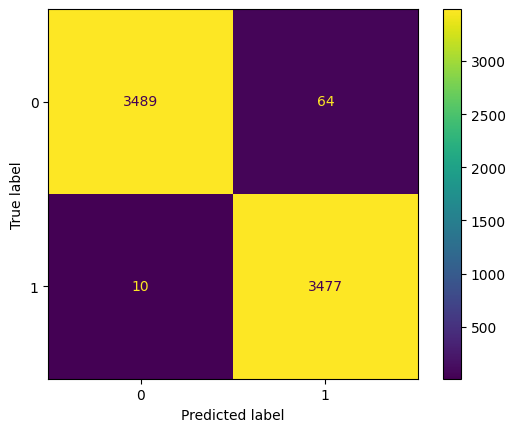

In [30]:
# visualization of the results in a confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()